Fitting 5 folds for each of 10 candidates, totalling 50 fits


2024-10-15 21:43:40,961 - INFO - Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini', 'bootstrap': True}
2024-10-15 21:43:41,147 - INFO - Test Accuracy: 98.87%
2024-10-15 21:43:41,147 - INFO - F1 Score: 0.99
2024-10-15 21:43:41,158 - INFO - Log Loss: 0.03
2024-10-15 21:43:41,159 - INFO - ROC AUC: 1.00
2024-10-15 21:43:41,195 - INFO - Classification Report:
              precision    recall  f1-score   support

       Risky       1.00      1.00      1.00      6573
    Moderate       0.97      0.94      0.96      1081
        Safe       0.93      0.97      0.95       645

    accuracy                           0.99      8299
   macro avg       0.97      0.97      0.97      8299
weighted avg       0.99      0.99      0.99      8299



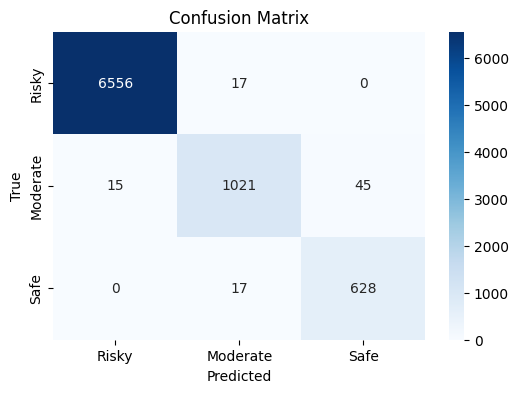

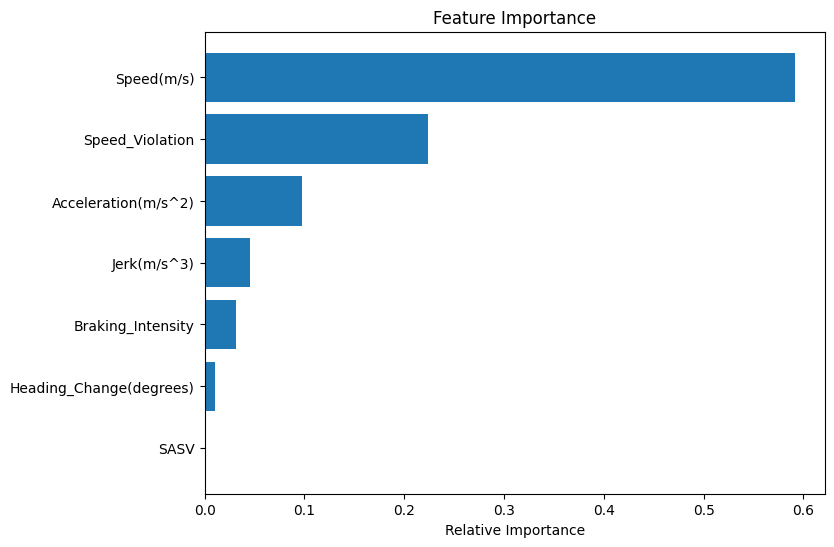

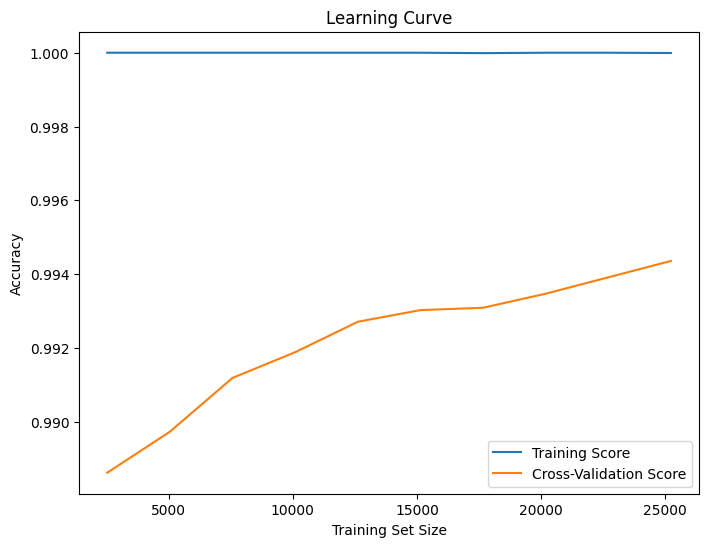

2024-10-15 21:44:11,464 - INFO - Cross-Validation Accuracy: 99.44% ± 0.07%


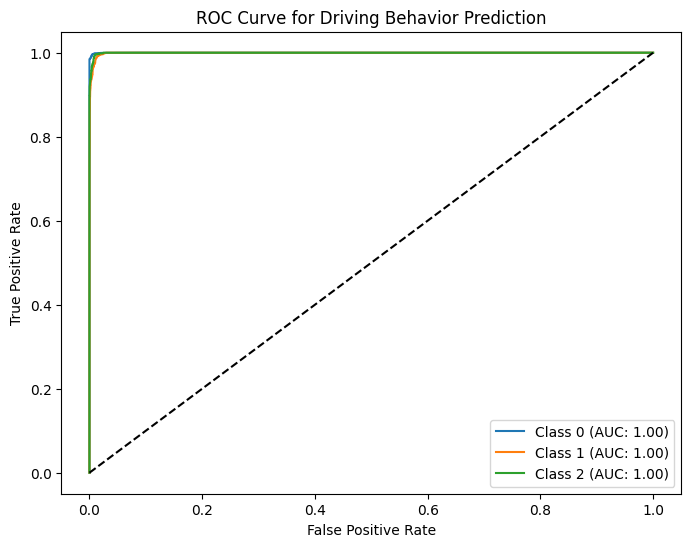

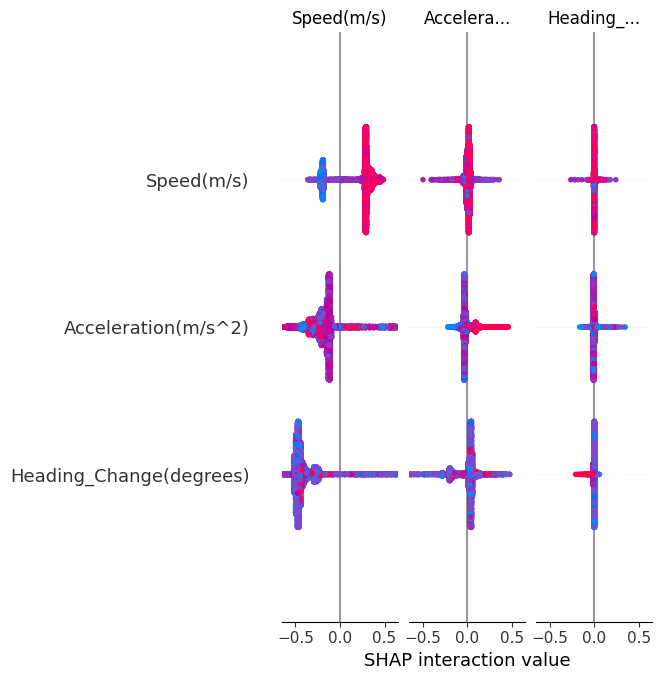

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, learning_curve, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score, log_loss, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest
import shap
import pickle
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Set up paths for saving models and scalers
model_directory = '../models'
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

# Load the processed data
df = pd.read_csv('../data/processed_data.csv')

# Select Features and Labels (Including interaction features)
X = df[['Speed(m/s)', 'Acceleration(m/s^2)', 'Heading_Change(degrees)', 'Jerk(m/s^3)', 
        'Braking_Intensity', 'SASV', 'Speed_Violation', 
        ]]
y = df['Driving_Category'].map({'Risky': 0, 'Moderate': 1, 'Safe': 2})  # Convert categories to numeric

# Train-test split (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Outlier detection using Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
yhat = iso.fit_predict(X_train)
mask = yhat != -1
X_train, y_train = X_train[mask], y_train[mask]

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for future use
scaler_path = os.path.join(model_directory, 'scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

# Handling Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# RandomForestClassifier setup
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Hyperparameter tuning using RandomizedSearchCV with 5-fold cross-validation
param_dist = {
    'n_estimators': [100, 150],  # Reduced range for faster search
    'max_depth': [None, 10, 20],  # Fewer depth options
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],  # Removed 'log2' for simplicity
    'bootstrap': [True],  # Removed 'False' to reduce search space
    'criterion': ['gini']  # Only 'gini' criterion
}

# Set up 5-fold StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=kf, n_jobs=-1, random_state=42, verbose=2)
random_search.fit(X_train_res, y_train_res)

# Best model parameters after hyperparameter tuning
logging.info("Best Hyperparameters: %s", random_search.best_params_)

# Train the best RandomForest model
best_rf_model = random_search.best_estimator_

# Evaluate on the test set
y_pred = best_rf_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
logloss = log_loss(y_test, best_rf_model.predict_proba(X_test_scaled))
roc_auc = roc_auc_score(y_test, best_rf_model.predict_proba(X_test_scaled), multi_class='ovr')

logging.info(f"Test Accuracy: {accuracy * 100:.2f}%")
logging.info(f"F1 Score: {f1:.2f}")
logging.info(f"Log Loss: {logloss:.2f}")
logging.info(f"ROC AUC: {roc_auc:.2f}")

# Save the trained model
model_path = os.path.join(model_directory, 'driving_data_model.pkl')
with open(model_path, 'wb') as model_file:
    pickle.dump(best_rf_model, model_file)

# ---------- Performance Metrics and Visualizations ---------- #

# 1. Classification Report
logging.info("Classification Report:\n%s", classification_report(y_test, y_pred, target_names=['Risky', 'Moderate', 'Safe']))

# 2. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Risky', 'Moderate', 'Safe'], 
            yticklabels=['Risky', 'Moderate', 'Safe'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 3. Feature Importance
importances = best_rf_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]  # Sort feature importances in descending order

plt.figure(figsize=(8, 6))
plt.title("Feature Importance")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# 4. Learning Curve
def plot_learning_curve(model, X_train, y_train, cv=kf):  # Use the same 5-fold cross-validation
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=cv, n_jobs=-1, 
                                                            train_sizes=train_sizes)
    
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label='Training Score')
    plt.plot(train_sizes, test_mean, label='Cross-Validation Score')
    plt.title('Learning Curve')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_learning_curve(best_rf_model, X_train_scaled, y_train)

# 5. Cross-validation Score Plot with 5-fold
cv_scores = cross_val_score(best_rf_model, X_train_scaled, y_train, cv=kf)
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)
logging.info(f"Cross-Validation Accuracy: {cv_mean * 100:.2f}% ± {cv_std * 100:.2f}%")

# 6. ROC Curves
y_prob = best_rf_model.predict_proba(X_test_scaled)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):  # For each class (Risky, Moderate, Safe)
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_prob[:, i])
    roc_auc[i] = roc_auc_score(y_test == i, y_prob[:, i])

plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC: {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Driving Behavior Prediction')
plt.legend(loc='best')
plt.show()

# 7. SHAP Interpretability
explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test)